# Introduction:

The first thing we notice when we are about to purchase a product would be the reviews and the sentiment associated with that product. For example, if we are going to purchase Apple Iphone in Amazon, we check the number of positive comments, negative comments and neutral comments. Sentiment analysis can be useful in many contexts. 

Understanding Consumer Opinions: Sentiment analysis helps businesses understand how customers feel about their products or services. This understanding can guide product development, marketing strategies, and customer service approaches.

Social Media Monitoring: By analyzing sentiments on social media platforms, companies can gauge public opinion about their brand, competitors, or industry trends. This insight is crucial for maintaining a positive brand image and making informed business decisions.

Enhancing Customer Experience: By identifying negative sentiments, companies can quickly address customer complaints and concerns, leading to improved customer satisfaction and loyalty.

Political Analysis: In politics, sentiment analysis can be used to understand public opinion on policies, politicians, and political events, influencing campaign strategies and policy-making.

Financial Markets: Investors use sentiment analysis to gauge market sentiment towards a particular stock, sector, or the market as a whole, helping in making investment decisions.

# Data:

The data has been sourced from Kaggle https://www.kaggle.com/competitions/tweet-sentiment-extraction

Training data: 27481 and 4 columns

Test Data: 3534 and 3 columns

# Model:

The idea behind this project was to leverage RNN/LSTM and Transformers for Sentiment Analysis

In [70]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import re
import string
from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, TimeDistributed,Bidirectional, GRU
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import torch
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, classification_report

In [36]:
train_data = pd.read_csv("/kaggle/input/tweet-sentiment-extraction/train.csv")

In [37]:
train_data.shape

(27481, 4)

In [38]:
test_data = pd.read_csv("/kaggle/input/tweet-sentiment-extraction/test.csv")

In [39]:
test_data.shape

(3534, 3)

# EDA

In [40]:
train_data.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [41]:
train_data.describe()

,textID,text,selected_text,sentiment
count,27481,27480,27480,27481
unique,27481,27480,22463,3
top,cb774db0d1,"I`d have responded, if I were going",good,neutral
freq,1,1,199,11118


# Distribution of target Sentiment

In [42]:
sentimentdata=train_data[['text','sentiment']].groupby(['sentiment']).count().reset_index().sort_values(by='text',ascending=False)

In [43]:
sentimentdata

,sentiment,text
1,neutral,11117
2,positive,8582
0,negative,7781


<Axes: xlabel='sentiment', ylabel='count'>

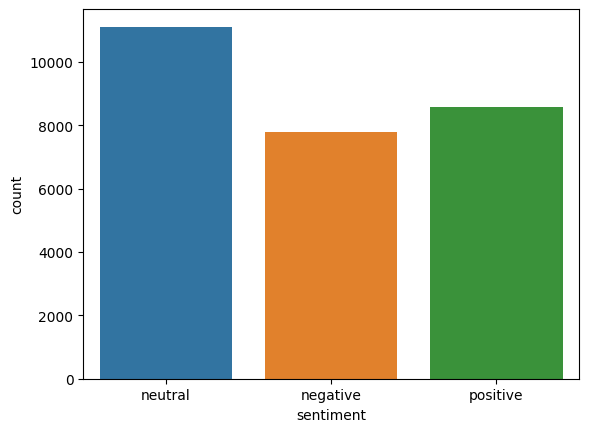

In [44]:
sns.countplot(x='sentiment',data=train_data)

# Get the number of words in text

In [45]:
train_data['Number_Words'] = train_data['text'].apply(lambda x:len(str(x).split()))

In [46]:
train_data['Number_Words'].describe()

count    27481.000000
mean        12.902442
std          6.926185
min          1.000000
25%          7.000000
50%         12.000000
75%         18.000000
max         33.000000
Name: Number_Words, dtype: float64

# Lets see the distribution of Number of Words

<Axes: >

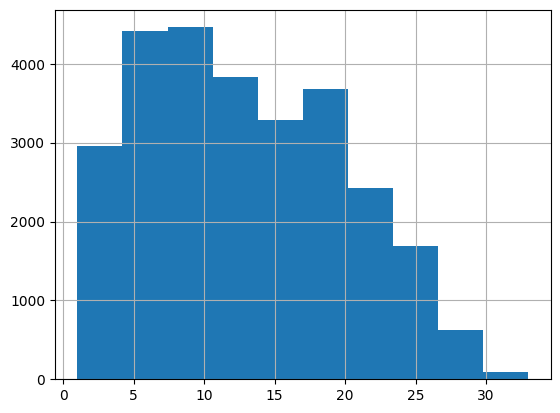

In [47]:
train_data['Number_Words'].hist()

# Will see the distribution of Positive, Negative and Neutral by the Number of Words

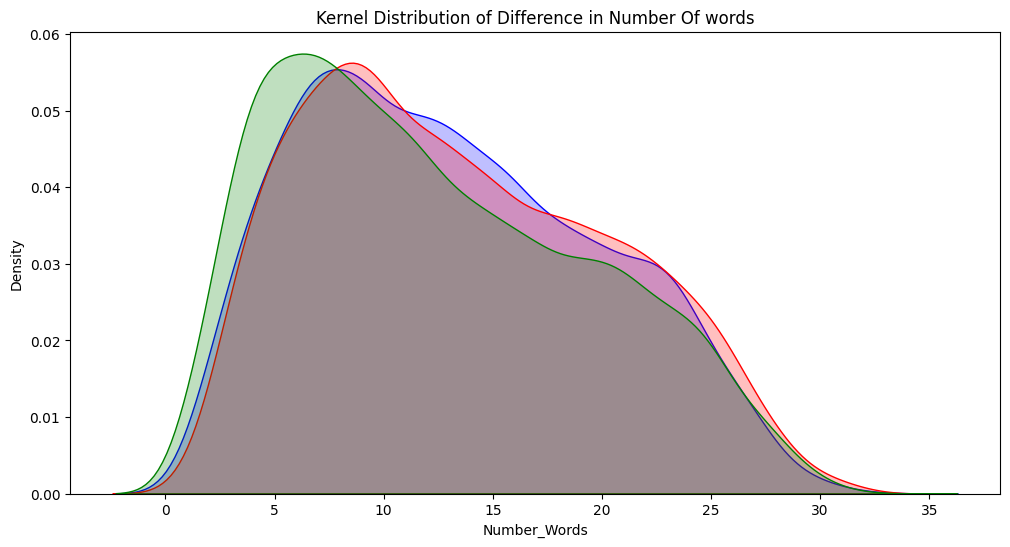

In [48]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train_data[train_data['sentiment']=='positive']['Number_Words'], shade=True, color="b").set_title('Kernel Distribution of Difference in Number Of words')
p2=sns.kdeplot(train_data[train_data['sentiment']=='negative']['Number_Words'], shade=True, color="r")
p3=sns.kdeplot(train_data[train_data['sentiment']=='neutral']['Number_Words'], shade=True, color="g")


# As a next step, we will go ahead with the cleaning of corpus

# Data Cleaning

1. Converting everything to lower case
2. Removing punctuation
3. Removing digits
4. Removing links if any
5. Removing Stopwords such as I, an, the etc. 

In [49]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [51]:
train_data['text'] = train_data['text'].apply(lambda x:clean_text(x))


# Background on RNNs:

RNNs are neural networks designed for processing sequences of data, such as time series data or natural language. They are "recurrent" because they perform the same task for every element of a sequence, with the output being dependent on previous computations. However, RNNs often struggle with long-term dependencies due to problems like vanishing gradients, where the influence of input data diminishes as the gap between relevant information and the point where it's needed grows. There are also Exploding Gradients problem, where the gradients become too big for the RNN and it would become difficult to train.

# Introduction to LSTM:

LSTM was introduced by Sepp Hochreiter and Jürgen Schmidhuber in 1997 as a solution to the vanishing gradient problem.An LSTM unit is composed of a cell, an input gate, an output gate, and a forget gate. The cell is responsible for "remembering" values over arbitrary time intervals; each of the three gates regulates the flow of information into and out of the cell. Key Components of LSTM:

# Cell State:

This is the core of the LSTM unit. It acts as a kind of conveyor belt, running straight down the entire chain of LSTM layers. It can carry relevant information throughout the processing of the sequence. Thus, information can be easily added or removed to the cell state via gates.

# Input Gate:

This gate decides what new information is going to be stored in the cell state.

# Forget Gate:

It determines what information is going to be thrown away from the cell state.

# Output Gate:

This gate decides what the next hidden state should be, which is used to make predictions or to pass on to the next LSTM cell.

# Applications of LSTM:

LSTM can be used for Translation, Time Series, Sentiment Analysis.

We are using LSTM for Sentiment Analysis

# Steps Followed For Modeling.

Tokenization

Create Train Test Split 70% and 30% - Training and Test Data

Fit a LSTM model on Training data and predict on test data.

In [59]:
labels = train_data['sentiment'].copy()
texts = train_data['text'].copy()

# Tokenization and Train Test Split

In [63]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)
onehot_encoded = tf.keras.utils.to_categorical(integer_encoded)

tokenizer = Tokenizer(num_words=12000)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

padded = pad_sequences(sequences, maxlen=20, padding='post', truncating='post')

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded, onehot_encoded, test_size=0.2, random_state=42)

# Model 1

In [64]:
# Model creation
model = Sequential([
    Embedding(12000, 16, input_length=20),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(3, activation='softmax')  # Output layer for 3 classes
])

# Compiling the model
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# Training the model
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))


Epoch 1/10
687/687 [==============================] - 22s 28ms/step - loss: 0.8971 - accuracy: 0.5669 - val_loss: 0.7601 - val_accuracy: 0.6653
Epoch 2/10
687/687 [==============================] - 19s 28ms/step - loss: 0.6718 - accuracy: 0.7175 - val_loss: 0.7197 - val_accuracy: 0.6918
Epoch 3/10
687/687 [==============================] - 19s 27ms/step - loss: 0.5756 - accuracy: 0.7708 - val_loss: 0.7292 - val_accuracy: 0.6793
Epoch 4/10
687/687 [==============================] - 19s 27ms/step - loss: 0.5085 - accuracy: 0.7985 - val_loss: 0.7773 - val_accuracy: 0.6827
Epoch 5/10
687/687 [==============================] - 19s 28ms/step - loss: 0.4613 - accuracy: 0.8238 - val_loss: 0.7833 - val_accuracy: 0.6904
Epoch 6/10
687/687 [==============================] - 19s 27ms/step - loss: 0.4208 - accuracy: 0.8422 - val_loss: 0.8293 - val_accuracy: 0.6753
Epoch 7/10
687/687 [==============================] - 19s 28ms/step - loss: 0.3905 - accuracy: 0.8546 - val_loss: 0.8622 - val_accuracy:

# Metrics for the Model

In [66]:
predictions = model.predict(X_test)#  Making predictions

predicted_labels = np.argmax(predictions, axis=1)# Decoding predictions For Predicted Labels
true_labels = np.argmax(y_test, axis=1)# Decoding predictions For Test Data

conf_matrix = confusion_matrix(true_labels, predicted_labels)# Confusion Matrix
print("Confusion Matrix:")
print(conf_matrix)


print("\nClassification Report:")
report = classification_report(true_labels, predicted_labels, target_names=label_encoder.classes_)
print(report)


172/172 [==============================] - 1s 6ms/step
Confusion Matrix:
[[1029  421  112]
 [ 450 1343  437]
 [  95  314 1296]]

Classification Report:
              precision    recall  f1-score   support

    negative       0.65      0.66      0.66      1562
     neutral       0.65      0.60      0.62      2230
    positive       0.70      0.76      0.73      1705

    accuracy                           0.67      5497
   macro avg       0.67      0.67      0.67      5497
weighted avg       0.67      0.67      0.67      5497



# Model 2

In [68]:
# Model creation
model = Sequential([
    Embedding(12000, 16, input_length=20),
    LSTM(256, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),  
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(3, activation='softmax')  # Output layer for 3 classes
])

# Compiling the model
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))# Training the model


Epoch 1/10
687/687 [==============================] - 81s 112ms/step - loss: 0.8873 - accuracy: 0.5740 - val_loss: 0.7526 - val_accuracy: 0.6789
Epoch 2/10
687/687 [==============================] - 76s 111ms/step - loss: 0.6743 - accuracy: 0.7185 - val_loss: 0.7051 - val_accuracy: 0.7042
Epoch 3/10
687/687 [==============================] - 76s 111ms/step - loss: 0.5725 - accuracy: 0.7737 - val_loss: 0.7100 - val_accuracy: 0.7117
Epoch 4/10
687/687 [==============================] - 76s 111ms/step - loss: 0.5053 - accuracy: 0.8043 - val_loss: 0.7831 - val_accuracy: 0.6962
Epoch 5/10
687/687 [==============================] - 76s 111ms/step - loss: 0.4565 - accuracy: 0.8289 - val_loss: 0.7649 - val_accuracy: 0.6969
Epoch 6/10
687/687 [==============================] - 76s 111ms/step - loss: 0.4186 - accuracy: 0.8453 - val_loss: 0.7926 - val_accuracy: 0.6878
Epoch 7/10
687/687 [==============================] - 76s 111ms/step - loss: 0.3879 - accuracy: 0.8578 - val_loss: 0.8814 - val_ac

In [69]:
predictions = model.predict(X_test)#  Making predictions

predicted_labels = np.argmax(predictions, axis=1)# Decoding predictions For Predicted Labels
true_labels = np.argmax(y_test, axis=1)# Decoding predictions For Test Data

conf_matrix = confusion_matrix(true_labels, predicted_labels)# Confusion Matrix
print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
report = classification_report(true_labels, predicted_labels, target_names=label_encoder.classes_)
print(report)


172/172 [==============================] - 4s 21ms/step
Confusion Matrix:
[[ 981  467  114]
 [ 362 1433  435]
 [  73  335 1297]]

Classification Report:
              precision    recall  f1-score   support

    negative       0.69      0.63      0.66      1562
     neutral       0.64      0.64      0.64      2230
    positive       0.70      0.76      0.73      1705

    accuracy                           0.68      5497
   macro avg       0.68      0.68      0.68      5497
weighted avg       0.67      0.68      0.67      5497



# GRU

GRU consists of two gates. Update gate and Reset gate


# Update gate: 

A combination of the input and forget gates, it decides how much of the past information needs to be passed along to the future.
# Reset gate: 

Determines how much of the past information to forget.

# Memory Cell: 

Unlike LSTMs, GRUs do not have a separate memory cell. They use the hidden state to transfer information. This can make them less effective than LSTMs at capturing long-term dependencies in some cases.

# Parameter Count: 

GRUs have fewer parameters due to their simpler structure, making them faster to train than LSTMs. This can be particularly advantageous in scenarios where computational resources are limited or when working with smaller datasets.

# Performance: 

GRUs perform comparably to LSTMs on many tasks, especially those that do not require modeling very long-term dependencies. 

In [71]:
# Model creation
model = Sequential([
    Embedding(12000, 16, input_length=20),
    GRU(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(3, activation='softmax')  # Output layer for 3 classes
])

# Compiling the model
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# Training the model
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))


Epoch 1/10
687/687 [==============================] - 18s 23ms/step - loss: 0.9830 - accuracy: 0.4916 - val_loss: 0.7683 - val_accuracy: 0.6640
Epoch 2/10
687/687 [==============================] - 15s 22ms/step - loss: 0.6999 - accuracy: 0.7029 - val_loss: 0.7199 - val_accuracy: 0.6906
Epoch 3/10
687/687 [==============================] - 15s 22ms/step - loss: 0.5935 - accuracy: 0.7611 - val_loss: 0.6952 - val_accuracy: 0.6997
Epoch 4/10
687/687 [==============================] - 15s 22ms/step - loss: 0.5176 - accuracy: 0.7972 - val_loss: 0.7020 - val_accuracy: 0.6971
Epoch 5/10
687/687 [==============================] - 15s 23ms/step - loss: 0.4611 - accuracy: 0.8239 - val_loss: 0.7444 - val_accuracy: 0.7046
Epoch 6/10
687/687 [==============================] - 15s 22ms/step - loss: 0.4116 - accuracy: 0.8474 - val_loss: 0.8233 - val_accuracy: 0.6946
Epoch 7/10
687/687 [==============================] - 15s 23ms/step - loss: 0.3754 - accuracy: 0.8598 - val_loss: 0.8591 - val_accuracy:

In [72]:
predictions = model.predict(X_test)#  Making predictions

predicted_labels = np.argmax(predictions, axis=1)# Decoding predictions For Predicted Labels
true_labels = np.argmax(y_test, axis=1)# Decoding predictions For Test Data

conf_matrix = confusion_matrix(true_labels, predicted_labels)# Confusion Matrix
print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
report = classification_report(true_labels, predicted_labels, target_names=label_encoder.classes_)
print(report)


172/172 [==============================] - 1s 5ms/step
Confusion Matrix:
[[1063  412   87]
 [ 435 1413  382]
 [  86  345 1274]]

Classification Report:
              precision    recall  f1-score   support

    negative       0.67      0.68      0.68      1562
     neutral       0.65      0.63      0.64      2230
    positive       0.73      0.75      0.74      1705

    accuracy                           0.68      5497
   macro avg       0.68      0.69      0.69      5497
weighted avg       0.68      0.68      0.68      5497



In [73]:
model.save('GRU.h5')

# Conclusion/Future Work:

We used Kaggle data to understand how LSTM/GRU can be used to predict sentiment of the data. 

If we look at the performance of the models GRU has provided a 0.01 increase over the performance of LSTM. 

Also we can leverage Transformers which uses Attention to understand the context of the tweet and understand how the sentiment changes wrt to different tweets.

The same model can be leveraged to Amazon or any other ecommerce sites to gauge the sentiment of the product

The model can be leveraged by political parties on announcement of certain populist measures. This can give a feel of how people is responding to their announcements. 
